## **Model 18: MobileNetV2 (fine-tune last 20 layers)**

**IMG_SIZE → (224, 224) (instead of (128,128)) because MobileNetV2, ResNet50, EfficientNetB0 all expect (224,224,3) input.**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# Use 224x224 for transfer learning
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets first (raw, no normalization yet)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Save class names before mapping
class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# Now split validation
val_size = int(0.2 * len(raw_train_ds))
val_ds = raw_train_ds.take(val_size)
train_ds = raw_train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = raw_test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


**Number of classes = inferred automatically from dataset**

In [10]:
NUM_CLASSES = len(class_names)

**Load MobileNetV2 base -> Build it -> Compile it**

In [11]:
base_model18 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),   # must match dataset
    include_top=False,
    weights="imagenet"
)

# Unfreeze last 20 layers
for layer in base_model18.layers[:-20]:
    layer.trainable = False
for layer in base_model18.layers[-20:]:
    layer.trainable = True

# Build model
x = layers.GlobalAveragePooling2D()(base_model18.output)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model18 = models.Model(inputs=base_model18.input, outputs=output)

# Compile
model18.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


**Callbacks**

In [12]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath='models/model18_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]


**Train**

In [13]:
history18 = model18.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7769 - loss: 0.5772
Epoch 1: val_loss improved from None to 0.28880, saving model to models/model18_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.8575 - loss: 0.3960 - val_accuracy: 0.9014 - val_loss: 0.2888 - learning_rate: 1.0000e-04
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9471 - loss: 0.1515
Epoch 2: val_loss did not improve from 0.28880
286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 242ms/step - accuracy: 0.9589 - loss: 0.1225 - val_accuracy: 0.9120 - val_loss: 0.2914 - learning_rate: 1.0000e-04
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9774 - loss: 0.0651
Epoch 3: val_loss improved from 0.28880 to 0.25594, saving model to models/model18_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 243ms/step - accuracy: 0.9858 - loss: 0.0500 - val_accuracy: 0.9366 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9948 - loss: 0.0278
Epoch 4: val_loss improved from 0.25594 to 0.21635, saving model to models/model18_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 70s 246ms/step - accuracy: 0.9963 - loss: 0.0207 - val_accuracy: 0.9393 - val_loss: 0.2163 - learning_rate: 1.0000e-04
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9965 - loss: 0.0129
Epoch 5: val_loss did not improve from 0.21635
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 247ms/step - accuracy: 0.9985 - loss: 0.0095 - val_accuracy: 0.9498 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9982 - loss: 0.0087
Epoch 6: val_loss improved from 0.21635 to 0.16523, saving model to models/model18_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.9983 - loss: 0.0080 - val_accuracy: 0.9533 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9960 - loss: 0.0114
Epoch 7: val_loss did not improve from 0.16523
286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 242ms/step - accuracy: 0.9965 - loss: 0.0111 - val_accuracy: 0.9507 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 8/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9934 - loss: 0.0185
Epoch 8: val_loss did not improve from 0.16523
286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 240ms/step - accuracy: 0.9939 - loss: 0.0188 - val_accuracy: 0.9481 - val_loss: 0.2781 - learning_rate: 1.0000e-04
Epoch 9/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9948 - loss: 0.0142
Epoch 9: val_loss did not improve from 0.16523

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
286/286 ━━━━━━━━━━━━━━━━━━━━ 69s 243ms/step - accuracy: 0.9954 - loss: 0.0

**Best model**

In [14]:
best_model18 = tf.keras.models.load_model("models/model18_best.h5")

**Evaluate**

In [15]:
from eval import evaluate_model
# Evaluate Model 18
evaluate_model(best_model18, history18, test_ds, 
               model_name="Model 18: MobileNetV2 (fine-tune last 20 layers)")


Model 18: MobileNetV2 (fine-tune last 20 layers) - Test accuracy: 0.9611
Model 18: MobileNetV2 (fine-tune last 20 layers) - Test loss: 0.1453
Model 18: MobileNetV2 (fine-tune last 20 layers) - Final training accuracy: 0.9996
Model 18: MobileNetV2 (fine-tune last 20 layers) - Final training loss: 0.0021
Model 18: MobileNetV2 (fine-tune last 20 layers) - Final validation accuracy: 0.9586
Model 18: MobileNetV2 (fine-tune last 20 layers) - Final validation loss: 0.1744


**Plot**

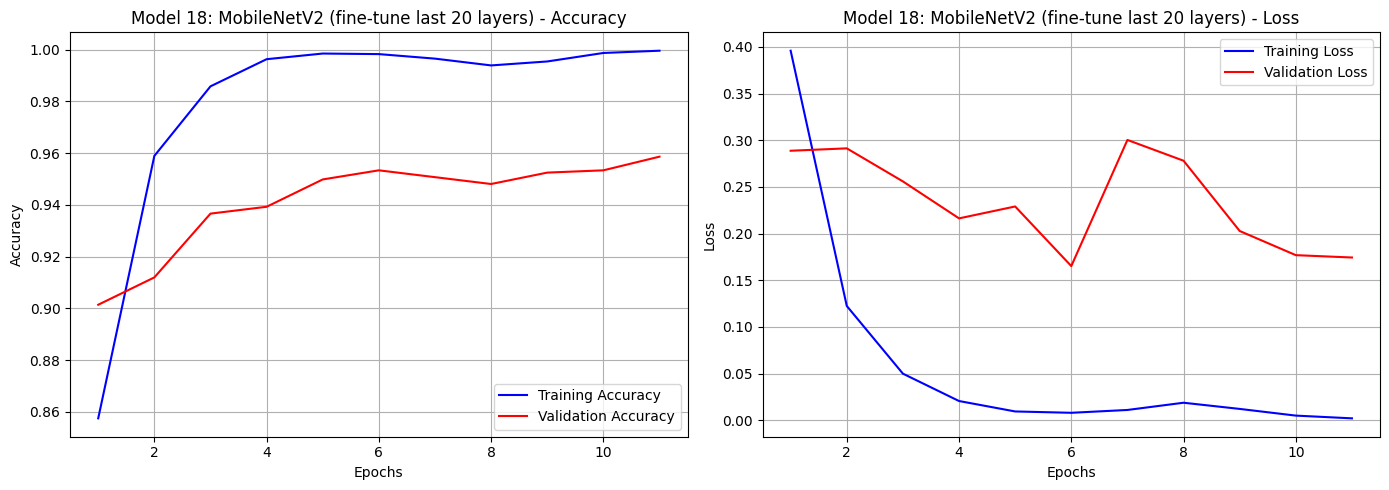

In [16]:
from plot_utils import plot_training_curves
plot_training_curves(history18, 
                     model_name="Model 18: MobileNetV2 (fine-tune last 20 layers)")

**Confusion matrix**

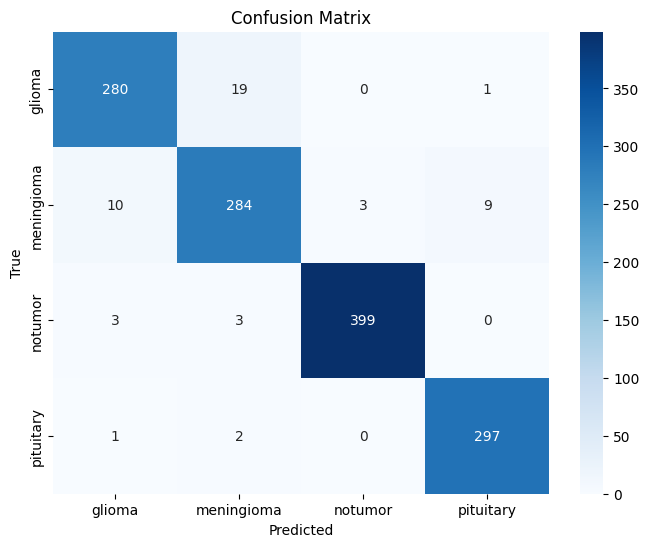


Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       300
  meningioma       0.92      0.93      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [17]:
from plot_utils import plot_confusion_matrix_from_dataset

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

plot_confusion_matrix_from_dataset("models/model18_best.h5", test_ds, class_names)
